# Test keypoints.py functionality

In [1]:
import os
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image

import data
import models
import pvnet_utils
import keypoints
reload(keypoints)
reload(pvnet_utils)

ROOT_DIR = "../dataset/LINEMOD"

In [2]:
reload(data)
NUM_KEYPOINTS = 2
x_train, x_test, y_train, y_test = pvnet_utils.get_test_train_split(ROOT_DIR,['duck', 'cat', 'lamp'], 
                                                                    test_size=0.33, 
                                                                    random_state=2, 
                                                                    shuffle=True)

train_dataset = data.LineModReader((x_train, y_train), num_keypoints= NUM_KEYPOINTS)
test_dataset = data.LineModReader((x_test, y_test), num_keypoints= NUM_KEYPOINTS)



### Prepare dummy data from gt labels

In [3]:
import training
reload(training)


sample = train_dataset[100]

# [1,num_v,h,w]
keypointVector = torch.Tensor(sample['class_vectormap']).permute(2,0,1).unsqueeze(0)

padded_label = training._padded_vector_label(keypoint_vector_label = keypointVector,
    class_Label=sample['class_label'],
    num_classes=12,
    num_keypoints=NUM_KEYPOINTS)

print(padded_label.size())

padded_segmentation = torch.zeros(1, 12 + 1, sample['class_mask'].shape[0], sample['class_mask'].shape[1])
padded_segmentation[0,sample['class_label'],:,:] = sample['class_mask']
print(padded_segmentation.size())


[1, 4, 480, 640]
torch.Size([1, 48, 480, 640])
torch.Size([1, 13, 480, 640])


torch.Size([480, 640])
Ransac iteration: 0
Worst_keypoint score: 1.0


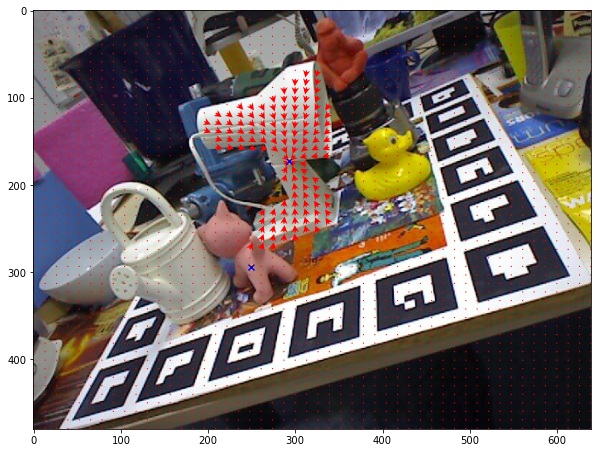

In [10]:
reload(keypoints)
b, c, h, w = keypointVector.size()

x,y = np.meshgrid(np.linspace(0,w-1,50),np.linspace(0,h-1,50))

u,v = keypointVector[0,0:2,y,x]
v = -v

found_keypoints, inClass, hypotheses, vote_cts, vectorPtsInClass = keypoints.findKeypoints(
    padded_segmentation,
    padded_label,
    [sample['class_label']],
    num_hypotheses=128
)


plt.figure(figsize=(10,10))
plt.imshow(train_dataset.tensorToImage(sample['img']))
plt.quiver(x,y,u,v, color= 'red', scale = 10, scale_units = 'inches',headwidth=6,headlength=6)

plt.scatter(sample['obj_keypoints_xy'][:,0], sample['obj_keypoints_xy'][:,1], marker='v', color="orange")
plt.scatter(found_keypoints[:,0], found_keypoints[:,1], marker='x', color="blue")

plt.show()
